In [21]:
import os, sys
# Reference: https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload

from data.generated.generated_data import get_noisy_nonlinear_with_non_noisy_labels

import pickle
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.manifold import TSNE

import common

title_fontsize = 24
fontsize = 24
legend_fontsize = 18
default_figure_size = (15, 8)

DATASET = "Generated Non-Linear"

In [2]:
X_train_gnnl, X_test_gnnl, y_train_gnnl, y_test_gnnl, y_test_non_noisy_gnnl =\
get_noisy_nonlinear_with_non_noisy_labels()

num_features = X_train_gnnl.shape[1]

In [4]:
pca = PCA(n_components=num_features)
pca.fit(X_train_gnnl)

PCA(n_components=10)

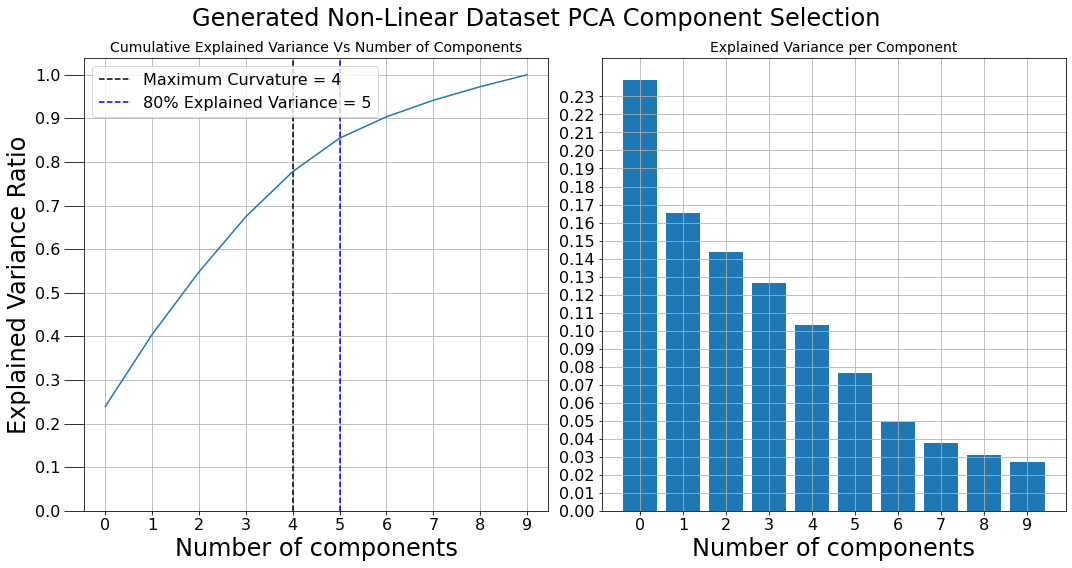

5


In [9]:
reload(common)
common.plot_pca_component_selection(X_train_gnnl, num_features, DATASET, x_tick_spacing=1, ax2_y_tick_spacing=0.01)

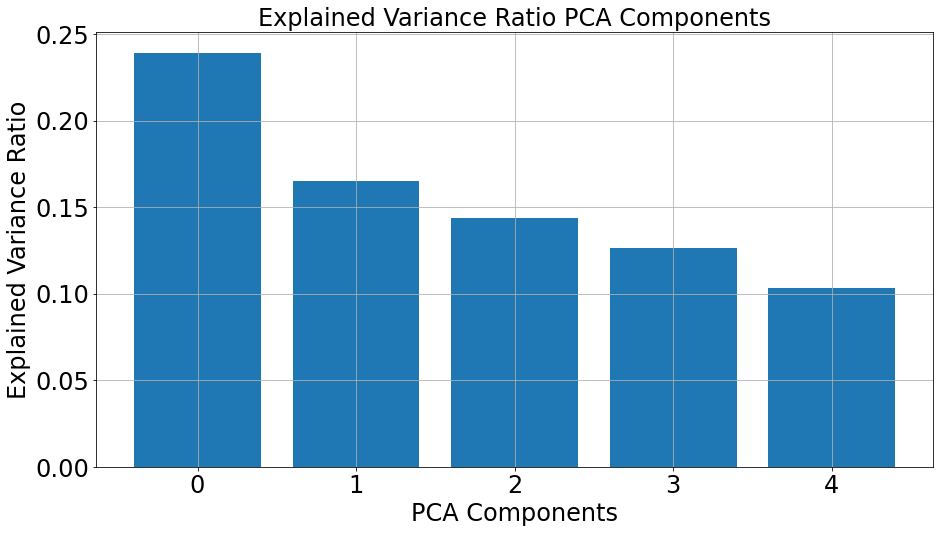

In [19]:
pca_best_num_components = 5
pca = PCA(n_components=pca_best_num_components)
pca.fit(X_train_gnnl)
X_train_transformed = pca.transform(X_train_gnnl)

plt.figure(figsize=default_figure_size)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title("Explained Variance Ratio PCA Components", fontsize=fontsize)
plt.xlabel("PCA Components", fontsize=fontsize)
plt.ylabel("Explained Variance Ratio", fontsize=fontsize)
plt.grid(True)


plt.bar(x=[i for i in range(pca.n_components)], height=pca.explained_variance_ratio_)
plt.show()

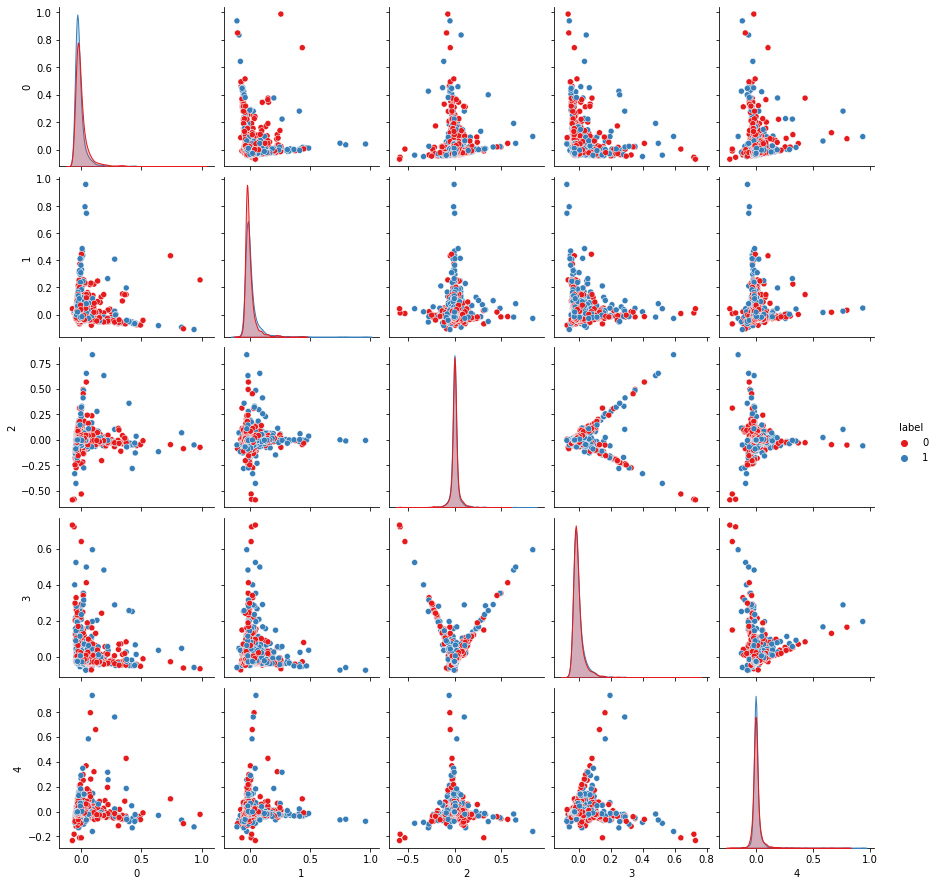

In [17]:
X_train_transformed = pca.transform(X_train_gnnl)
X_Vis = pd.DataFrame(X_train_transformed)
X_Vis['label'] = y_train_gnnl

sns.pairplot(X_Vis, hue="label", palette="Set1")

# ICA

In [85]:
n_components = num_features
n_components_x = [i for i in range(1, num_features+1)]
ica = FastICA(random_state=42)
kurtosis = []
ica_reconstruction_error = []

for n in n_components_x:
    print("Running ICA for {} components".format(n))
    ica.set_params(n_components=n)
    X_train_gnnl_ica = ica.fit_transform(X_train_gnnl)
    tmp_df = pd.DataFrame(X_train_gnnl_ica)
    tmp_kurt = tmp_df.kurt(axis=0)
    kurtosis.append(tmp_kurt.abs().mean())
    
    # https://intellipaat.com/community/22811/pca-projection-and-reconstruction-in-scikit-learn
    X_projected = ica.inverse_transform(X_train_gnnl_ica)
    loss = ((X_train_gnnl - X_projected) ** 2).mean()
    ica_reconstruction_error.append(np.sum(loss))


Running ICA for 1 components
Running ICA for 2 components
Running ICA for 3 components
Running ICA for 4 components
Running ICA for 5 components
Running ICA for 6 components
Running ICA for 7 components
Running ICA for 8 components
Running ICA for 9 components
Running ICA for 10 components


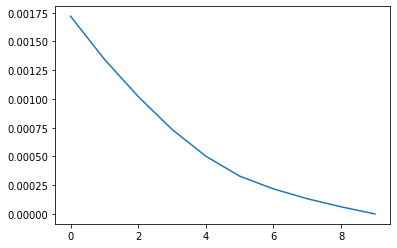

In [86]:
plt.plot(ica_reconstruction_error)

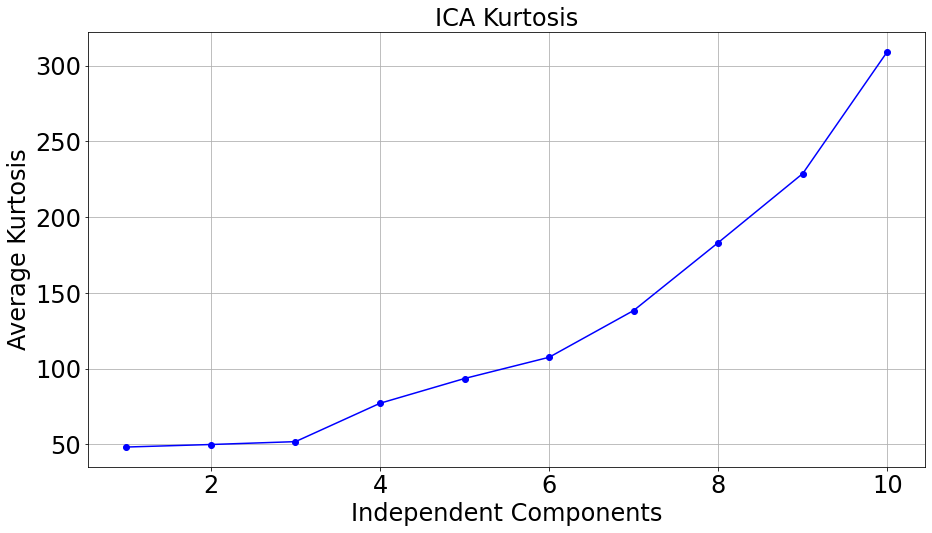

In [88]:
plt.figure(figsize=default_figure_size)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title("ICA Kurtosis", fontsize=fontsize)
plt.xlabel("Independent Components", fontsize=fontsize)
plt.ylabel("Average Kurtosis", fontsize=fontsize)
plt.plot(n_components_x, kurtosis, 'bo-')
# plt.axvline(x=5, color='k', linestyle='--', label="k = {}".format(5))
# plt.xticks(dims[::5])
plt.grid(True)
plt.show()

In [93]:
best_ica_components=num_features
ica = FastICA(random_state=42)
ica.set_params(n_components=best_ica_components)
X_train_gnnl_ica = ica.fit_transform(X_train_gnnl)
X_train_gnnl_ica_df = pd.DataFrame(X_train_gnnl_ica)
ica_kurt = X_train_gnnl_ica_df.kurt(axis=0)


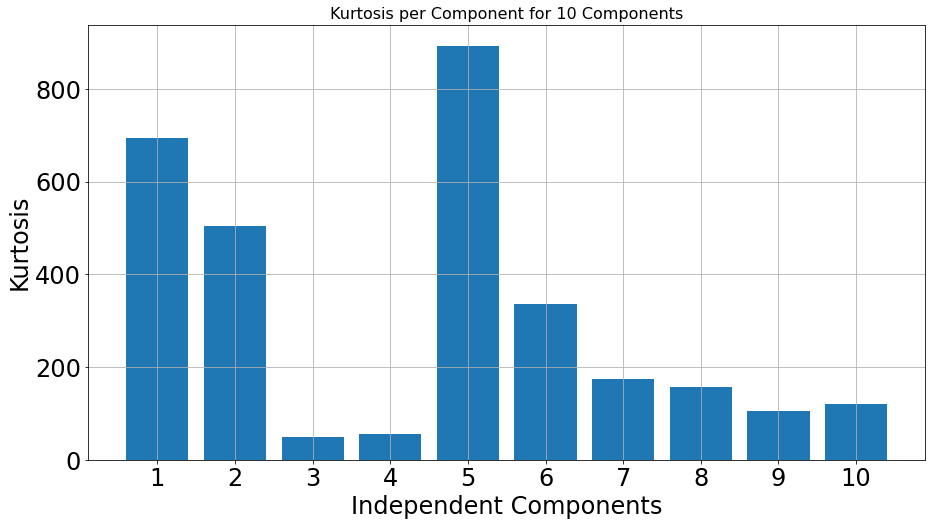

In [94]:
plt.figure(figsize=default_figure_size)
plt.xticks(n_components_x, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.bar(x=n_components_x, height=ica_kurt)
plt.xlabel("Independent Components", fontsize=fontsize)
plt.ylabel("Kurtosis", fontsize=fontsize)
plt.title("Kurtosis per Component for {} Components".format(best_ica_components), fontsize=16)

plt.grid()


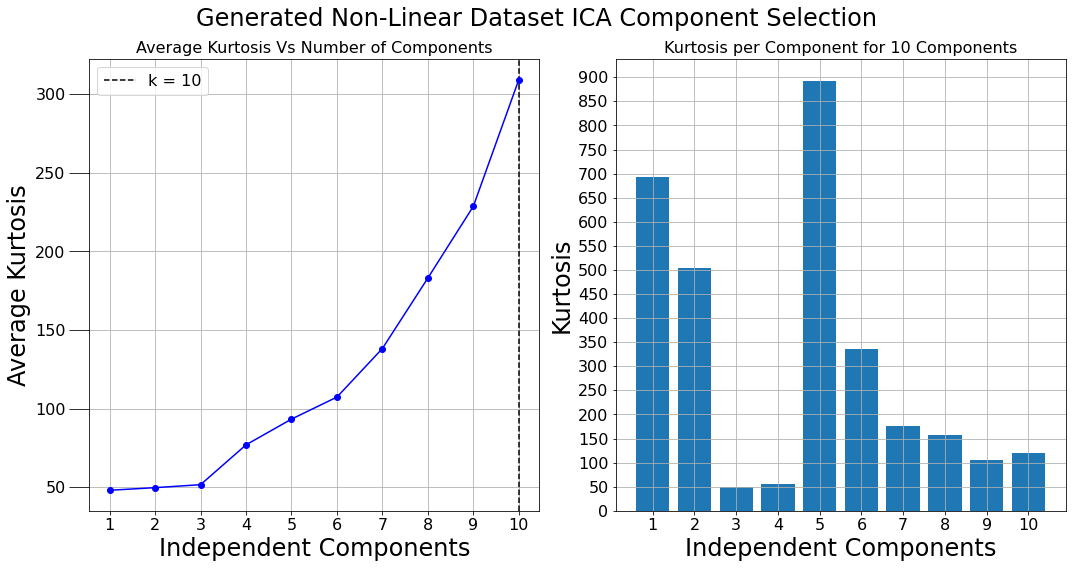

In [100]:
reload(common)
common.plot_ica_selection(n_components_x, kurtosis, best_ica_components, ica_kurt, DATASET,x_tick_spacing=1, ax2_y_ticks=50)

In [101]:
for i in range(1, 300, 20):
    print("{} limit = {} components".format(i, len(ica_kurt[ica_kurt>i])))


1 limit = 10 components
21 limit = 10 components
41 limit = 10 components
61 limit = 8 components
81 limit = 8 components
101 limit = 8 components
121 limit = 6 components
141 limit = 6 components
161 limit = 5 components
181 limit = 4 components
201 limit = 4 components
221 limit = 4 components
241 limit = 4 components
261 limit = 4 components
281 limit = 4 components


In [113]:
print(X_train_gnnl_ica.shape)
X_train_gnnl_ica[:, ica_kurt>200].shape


print(X_train_gnnl_ica_df[X_train_gnnl_ica_df.columns[ica_kurt>180]])

print(pd.DataFrame(X_train_gnnl_ica[:, ica_kurt>180]))

(2800, 10)
             0         1         4         5
0    -0.002498 -0.003494 -0.003241  0.001099
1    -0.001183 -0.004200 -0.001543 -0.001121
2    -0.006849  0.006906 -0.004004 -0.005489
3     0.028440  0.000575 -0.003357 -0.004849
4    -0.001754 -0.005647  0.002017 -0.003106
...        ...       ...       ...       ...
2795  0.011387  0.000536  0.747705 -0.015133
2796  0.011262  0.017279 -0.003471 -0.003062
2797 -0.006941 -0.007000  0.002968 -0.002822
2798  0.024286 -0.002009 -0.003173 -0.002364
2799  0.004268  0.001036 -0.003884 -0.005120

[2800 rows x 4 columns]
             0         1         2         3
0    -0.002498 -0.003494 -0.003241  0.001099
1    -0.001183 -0.004200 -0.001543 -0.001121
2    -0.006849  0.006906 -0.004004 -0.005489
3     0.028440  0.000575 -0.003357 -0.004849
4    -0.001754 -0.005647  0.002017 -0.003106
...        ...       ...       ...       ...
2795  0.011387  0.000536  0.747705 -0.015133
2796  0.011262  0.017279 -0.003471 -0.003062
2797 -0.006941 -0.0

In [116]:
from sklearn import random_projection

reconstruction_errors = []
random_states=[]

for state in range(1,11):
    state_reconstruction_error = []
    for n in n_components_x:
        transformer = random_projection.GaussianRandomProjection(n_components=n, random_state=state)
        X_new = transformer.fit_transform(X_train_gnnl)

        # https://piazza.com/class/kjwtraqiv511du?cid=623_f43
        transformed_data = transformer.fit_transform(X_train_gnnl)
        inverse_data = np.linalg.pinv(transformer.components_.T)
        reconstructed_data = transformed_data.dot(inverse_data)

        state_reconstruction_error.append(np.sum(((X_train_gnnl - reconstructed_data) ** 2).mean()))
    reconstruction_errors.append(state_reconstruction_error)
    random_states.append(state)

    


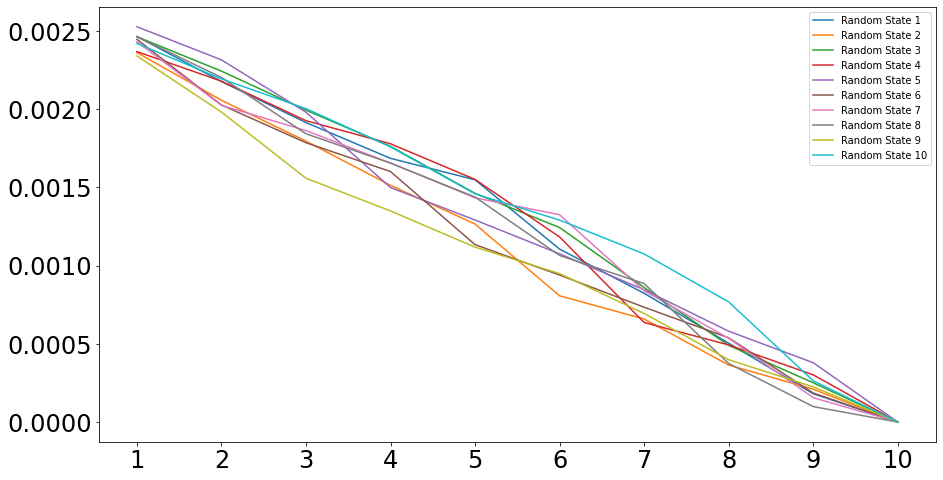

3

In [122]:
plt.figure(figsize=default_figure_size)
plt.xticks(n_components_x, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
for reconstruction_error, state in zip(reconstruction_errors, random_states):
    plt.plot(n_components_x, reconstruction_error, label="Random State {}".format(state))


plt.legend()
plt.show()


In [63]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree

base_estimator=tree.DecisionTreeClassifier(ccp_alpha=0.001, max_depth=3)
final_params={'base_estimator': base_estimator, 'learning_rate': 0.1, 'n_estimators': 9}

clf = AdaBoostClassifier(**final_params)
clf.fit(X_train_gnnl, y_train_gnnl)
print("Train Accuracy: {}%".format(round(clf.score(X_train_gnnl, y_train_gnnl)*100, 1)))
print("Test Accuracy: {}%".format(round(clf.score(X_test_gnnl, y_test_gnnl)*100, 1)))

Train Accuracy: 74.1%
Test Accuracy: 72.0%


[]

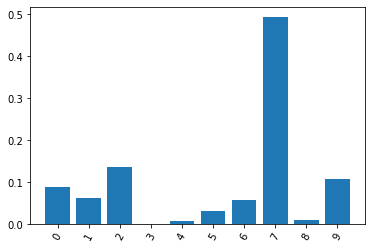

In [73]:
plt.bar(x=[i for i in pd.DataFrame(X_train_gnnl).columns], height=clf.feature_importances_)
plt.xticks([i for i in pd.DataFrame(X_train_gnnl).columns], rotation=60)
plt.plot()

In [126]:
print(X_train_gnnl[:, clf.feature_importances_>0.06].shape)
print(len(pd.DataFrame(X_train_gnnl).columns[clf.feature_importances_>0.06]))

(2800, 5)
5
